# Prompt Chaining


**Prompt chaining** is a method where each AI (LLM) call builds on the result of the previous one. It breaks a task into smaller steps, with each step handled one at a time. You can also add checks between steps to make sure everything is going as planned.

**When to use it:** Prompt chaining works best when a task can be clearly divided into fixed parts. It's a good choice if you want better accuracy, even if it takes a bit longer, by making each step simpler for the AI to handle.

We can take an example about a RAG use case, we check where the retrieved document is a relevant context or not, then we pass the context to LLM and check the LLM output if the generated output is relevant or not.


## Prerequisite

- [Ollama](https://ollama.com/) installed to generate the graph
- Taviley search tool to retrieve context for our usecase.

Download the granite model

```sh
ollama pull granite3.2:2b  
```


In [1]:
%%capture --no-stderr
## lets start with installing all the required libraries
%pip install --upgrade --quiet langgraph  langchain langchain-community langchain-ollama langchain-experimental python-dotenv langchain_core tavily-python

In [1]:
## Load the environment variable from .env file

import os
from dotenv import load_dotenv
load_dotenv()

True

### LLM Model using OLLAMA

In [2]:
### LLM
from langchain_ollama import ChatOllama
from IPython.display import display

local_llm = "llama3.2:3b-instruct-fp16"
llm = ChatOllama(model=local_llm, temperature=0)
llm_json_mode = ChatOllama(model=local_llm, temperature=0, format="json")

In [3]:
## Testing the LLM model

from langchain_core.messages import HumanMessage

# Create a message
msg = HumanMessage(content="Hello how are you?", name="Himadri")

# Message list
messages = [msg]

# Invoke the model with a list of messages 
response=llm.invoke(messages)
print(response.content)

I'm just a language model, so I don't have feelings or emotions like humans do. However, I'm functioning properly and ready to assist you with any questions or tasks you may have! How can I help you today?


### Search tool Tavily to retrieve context from internet

In [4]:
### Search
from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults(
    max_results=3,
    include_answer=True,
    include_raw_content=True,
    include_images=False,
    # search_depth="advanced",
    # include_domains = []
    # exclude_domains = []
)

In [5]:
question = "What is IBM and whats is business?"
docs = web_search_tool.invoke({'query': question} )
docs

[{'title': 'IBM (International Business Machines Corporation) - TechTarget',
  'url': 'https://www.techtarget.com/searchitchannel/definition/IBM-International-Business-Machines',
  'content': "What is IBM (International Business Machines Corporation)?\nIBM (International Business Machines Corporation) is a multinational technology company headquartered in Armonk, N.Y. It was founded in 1911 as the Computing-Tabulating-Recording Company (CTR) and was later renamed to IBM in 1924. IBM is one of the world's largest IT companies, with operations in over 170 countries. [...] IBM is known for its hardware and software products, including computers, servers, storage systems and networking equipment. It also provides consulting, technology and business services, such as cloud computing, data analytics and artificial intelligence (AI). IBM's research and development efforts have contributed to numerous technological innovations, including the development of the first programmable computer, the 

In [6]:
for d in docs:
    print(d["content"])

What is IBM (International Business Machines Corporation)?
IBM (International Business Machines Corporation) is a multinational technology company headquartered in Armonk, N.Y. It was founded in 1911 as the Computing-Tabulating-Recording Company (CTR) and was later renamed to IBM in 1924. IBM is one of the world's largest IT companies, with operations in over 170 countries. [...] IBM is known for its hardware and software products, including computers, servers, storage systems and networking equipment. It also provides consulting, technology and business services, such as cloud computing, data analytics and artificial intelligence (AI). IBM's research and development efforts have contributed to numerous technological innovations, including the development of the first programmable computer, the first hard drive and the first computer virus.
History of IBM
International Business Machines Corporation (IBM) is an American multinational technology company. It was founded in New York as the

### Document Grade

In [7]:
### Retrieval Grader
from langchain_core.messages import HumanMessage, SystemMessage
import json

# Doc grader instructions
doc_grader_instructions = """You are a grader assessing relevance of a retrieved document to a user question.

If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant."""

# Grader prompt
doc_grader_prompt = """Here is the retrieved document: \n\n {document} \n\n Here is the user question: \n\n {question}. 

This carefully and objectively assess whether the document contains at least some information that is relevant to the question.

Return JSON with single key, binary_score, that is 'yes' or 'no' score to indicate whether the document contains at least some information that is relevant to the question."""

# Test
doc_txt = '\n\n\n'.join(d["content"] for d in docs)

doc_grader_prompt_formatted = doc_grader_prompt.format(
    document=doc_txt, question=question
)
result = llm_json_mode.invoke(
    [SystemMessage(content=doc_grader_instructions)]
    + [HumanMessage(content=doc_grader_prompt_formatted)]
)
json.loads(result.content)

{'binary_score': 'yes'}

### LLM Generation

In [8]:
### Generate

# Prompt
rag_prompt = """You are an assistant for question-answering tasks. 

Here is the context to use to answer the question:

{context} 

Think carefully about the above context. 

Now, review the user question:

{question}

Provide an answer to this questions using only the above context. 

Use three sentences maximum and keep the answer concise.

Answer:"""


rag_prompt_formatted = rag_prompt.format(context=doc_txt, question=question)
generation = llm.invoke([HumanMessage(content=rag_prompt_formatted)])

import textwrap

print(textwrap.fill(generation.content, width=100))  # Adjust width as needed

IBM (International Business Machines Corporation) is a multinational technology company
headquartered in Armonk, N.Y., founded in 1911 as the Computing-Tabulating-Recording Company and
later renamed to IBM in 1924. The company operates in over 170 countries and provides hardware and
software products, consulting services, cloud computing, data analytics, and artificial intelligence
(AI). Its business model is centered around three main segments: Software, Consulting, and
Infrastructure, generating revenue through software solutions, consulting services, and
infrastructure-related products.


### Lets build the Prompt Chaining workflow using LangGraph

In [9]:
from typing_extensions import TypedDict, List, Any
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
from langgraph.graph import MessagesState


# Graph state
class State(TypedDict):
    question: str
    context: List[Any]
    context_grade: str
    message: str


#### Define nodes

In [32]:
# Nodes

def search_web(state: State):
    """First node, make an api call to web using tavily"""

    web_results = web_search_tool.invoke({'query': state['question']})

    print("___SEARCH__WEB___")

    return {"context": web_results}

def grade_context(state: State):
    """Grade context found in the web search"""

    print("___GRADE_CONTEXT___")
    
    doc_txt = '\n\n\n'.join(d["content"] for d in state["context"])

    doc_grader_prompt_formatted = doc_grader_prompt.format(
        document=doc_txt, question=state['question']
    )
    result = llm_json_mode.invoke(
        [SystemMessage(content=doc_grader_instructions)]
        + [HumanMessage(content=doc_grader_prompt_formatted)]
    )
    result = json.loads(result.content)
    if result["binary_score"] == "yes":
        return "yes"

    return "no"

def llm_generation(state: State):
    """Generate answer based on graded context"""

    print("___LLM_GENERATION___")
    
    doc_txt = '\n\n\n'.join(d["content"] for d in state["context"])

    rag_prompt_formatted = rag_prompt.format(context=doc_txt, question=state['question'])
    generation = llm.invoke([HumanMessage(content=rag_prompt_formatted)])

    print(generation)
    
    return {"message": generation.content}
    


#### Define workflow

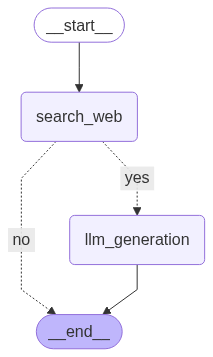

In [33]:
# Build workflow
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

workflow = StateGraph(State)

# Add nodes
workflow.add_node("search_web", search_web)
workflow.add_node("llm_generation", llm_generation)

# Add edges to connect nodes
workflow.add_edge(START, "search_web")

workflow.add_conditional_edges(
    "search_web", grade_context, {"yes": "llm_generation", "no": END}
)

workflow.add_edge("llm_generation", END)

# Compile
graph = workflow.compile()

# Show workflow
display(Image(graph.get_graph().draw_mermaid_png()))

In [28]:
# Invoke
state = graph.invoke({"question": "what is IBM?"})

___SEARCH__WEB___
___GRADE_CONTEXT___
___LLM_GENERATION___
content="IBM is a multinational corporation specializing in computer technology and information technology consulting. It was founded in 1911 as the Computing-Tabulating-Recording Company, which later became International Business Machines Corporation (IBM) in 1924. The company is headquartered in Armonk, New York, and has since grown to become one of the world's largest computer companies and systems integrators." additional_kwargs={} response_metadata={'model': 'llama3.2:3b-instruct-fp16', 'created_at': '2025-05-21T18:24:42.702404Z', 'done': True, 'done_reason': 'stop', 'total_duration': 28698116348, 'load_duration': 26858329, 'prompt_eval_count': 709, 'prompt_eval_duration': 11744000000, 'eval_count': 78, 'eval_duration': 16926000000, 'model_name': 'llama3.2:3b-instruct-fp16'} id='run--d1ab2dca-d31a-458e-8d2b-97b717551c5b-0' usage_metadata={'input_tokens': 709, 'output_tokens': 78, 'total_tokens': 787}


In [34]:
state["message"]

"IBM is a multinational corporation specializing in computer technology and information technology consulting. It was founded in 1911 as the Computing-Tabulating-Recording Company, which later became International Business Machines Corporation (IBM) in 1924. The company is headquartered in Armonk, New York, and has since grown to become one of the world's largest computer companies and systems integrators."

#### Chain of thought

In [35]:
from langchain_core.prompts import PromptTemplate
from langchain.chains import LLMChain

# 1. Initialize the LLM
# Replace with your actual API key
# Make sure to set your GOOGLE_API_KEY as an environment variable
# import os
# os.environ["GOOGLE_API_KEY"] = "YOUR_API_KEY"

# 2. Define the Chain of Thought Prompt Template
# This is the core of the CoT. We explicitly ask the LLM to think step by step.
cot_prompt_template = PromptTemplate(
    input_variables=["problem"],
    template="""You are a helpful AI assistant tasked with solving word problems.
Please think step by step and show your reasoning clearly.
Here is the problem:

{problem}

Let's break this down step-by-step:
"""
)

# 3. Create an LLMChain
# This chain will take the prompt and the LLM, and execute the reasoning.
cot_chain = LLMChain(prompt=cot_prompt_template, llm=llm)

# 4. The Word Problem
word_problem = "Alice has 3 apples. Bob gives her 5 more apples. Then, Alice eats 2 apples. How many apples does Alice have now? If each apple costs $0.75, what is the total value of her remaining apples?"

# 5. Run the Chain
print("Running the Chain of Thought agent...")
result = cot_chain.invoke({"problem": word_problem})

# 6. Print the Result
print("\n--- AI Agent's Reasoning ---")
print(result['text'])
print("\n--------------------------")

# Expected Output Structure (the exact wording may vary based on the LLM):
# --- AI Agent's Reasoning ---
# Step 1: Alice starts with 3 apples.
# Step 2: Bob gives her 5 more apples. So, 3 + 5 = 8 apples.
# Step 3: Alice eats 2 apples. So, 8 - 2 = 6 apples.
# Step 4: Alice now has 6 apples.
# Step 5: Each apple costs $0.75. So, 6 apples * $0.75/apple = $4.50.
# Final Answer: Alice has 6 apples, and the total value of her remaining apples is $4.50.
# --------------------------

/var/folders/m_/k36dt1fd2k33rt768hhldk9h0000gn/T/ipykernel_99645/4180317221.py:26: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 1.0. Use :meth:`~RunnableSequence, e.g., `prompt | llm`` instead.
  cot_chain = LLMChain(prompt=cot_prompt_template, llm=llm)


Running the Chain of Thought agent...

--- AI Agent's Reasoning ---
I'd be happy to help you solve this problem step by step.

**Step 1: Determine the initial number of apples**

Alice starts with 3 apples.

**Step 2: Add the additional apples given by Bob**

Bob gives Alice 5 more apples. To find the new total, we add 5 to the initial number:

3 (initial apples) + 5 (additional apples) = 8

So, now Alice has 8 apples.

**Step 3: Subtract the apples eaten by Alice**

Alice eats 2 apples. To find out how many apples she has left, we subtract 2 from the total:

8 (total apples) - 2 (apples eaten) = 6

Therefore, Alice now has 6 apples.

**Step 4: Calculate the total value of her remaining apples**

Each apple costs $0.75. To find the total value of her remaining apples, we multiply the number of apples by the cost per apple:

6 (remaining apples) x $0.75 (cost per apple) = $4.50

So, the total value of Alice's remaining apples is $4.50.

Let me know if you have any questions or need furt